In [1]:
from torch import nn
from torch.nn import functional as F
class Residual_0(nn.Module):
   
    def __init__(self,channel):
        super().__init__()
        self.Conv1=nn.Conv2d(channel,channel,kernel_size=3,padding=1)
        self.Conv2=nn.Conv2d(channel, channel,kernel_size=3, padding=1)        
        self.BatchNorm1=nn.BatchNorm2d(channel)
        self.BatchNorm2=nn.BatchNorm2d(channel)
        
        
    def forward(self,X):
        
        Y=F.relu(self.BatchNorm1(self.Conv1(X)))
        Y=self.BatchNorm2(self.Conv2(Y))

        
        return F.relu(Y+X)
        
class Residual_1(nn.Module):
   
    def __init__(self,in_channel,out_channel, strides=1):
        super().__init__()
        self.Conv1=nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1,stride=strides)
        self.Conv2=nn.Conv2d(out_channel, out_channel,kernel_size=3, padding=1)
    
        self.Conv3 = nn.Conv2d(in_channel, out_channel,
                                   kernel_size=1, stride=strides)
        
        
        self.BatchNorm1=nn.BatchNorm2d(out_channel)
        
        self.BatchNorm2=nn.BatchNorm2d(out_channel)

        self.BatchNorm3=nn.BatchNorm2d(out_channel)
        
    def forward(self,X):
        
        Y=F.relu(self.BatchNorm1(self.Conv1(X)))
        Y=self.BatchNorm2(self.Conv2(Y))
        Y1=self.BatchNorm3(self.Conv3(X))
        
        return F.relu(Y+Y1)

In [2]:
import torch
def resnet_block(in_channels, out_channels, num_residuals,
             first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual_1(in_channels, out_channels,
                                 strides=2))
        else:
            blk.append(Residual_0(out_channels))
            
    return blk



class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        layers=[
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *resnet_block(64, 64, 2, first_block=True),
            *resnet_block(64, 128, 2),
            *resnet_block(128, 256, 2),
            *resnet_block(256, 512, 2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(512, 10)
        ]
        
        self.net=nn.Sequential(*layers)
    def forward(self,X):
        return self.net(X)
        

In [3]:
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
aug=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([96,96]),
    transforms.ToTensor()]
)

class FashionMnist(Dataset):

    def __init__(self, img_path, label_path):
        super().__init__()
        self.load_data_from_path(img_path, label_path)

    def __getitem__(self, index):
        return self.imgs[index], self.labels[index]

    def __len__(self):
        return self.img_num

    def load_data_from_path(self, img_path, label_path):
        with open(img_path, 'rb') as f:
            s = f.read()

        self.img_num = int(s[4:8].hex(), 16)
        self.imgs = torch.FloatTensor(list(iter(s[16:])))
        # print(self.img_num,self.imgs)
        self.imgs = torch.reshape(self.imgs, (-1, 1, 28, 28))
        # print(self.imgs.shape)
        with open(label_path, 'rb') as f:
            s = f.read()
        self.labels = torch.tensor(list(iter(s[8:])))
        # print(self.labels.shape)



def convert_to_227(img,aug):
    return aug(img).numpy().tolist()


def collate_fn(batch):
    inputs, labels = [], []
    for X, y in batch:
        inputs.append(convert_to_227(X, aug))
        labels.append(y)
        
    
    return torch.Tensor(inputs), torch.tensor(labels)

train_img_path='D:/datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte'
train_label_path='D:/datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte'
test_img_path='D:/datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte'
test_label_path='D:/datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte'

train_data=FashionMnist(train_img_path,train_label_path)
test_data=FashionMnist(test_img_path,test_label_path)
train_iter=DataLoader(train_data,batch_size=64,shuffle=True,collate_fn=collate_fn)
test_iter=DataLoader(test_data,batch_size=64,shuffle=True,collate_fn=collate_fn)

In [4]:

def precise(test_iter,net,device):
    total=0
    correct=0
    with torch.no_grad():
        for X,y in test_iter:
            total+=len(X)
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            out_put=torch.argmax(y_hat,dim=-1)
            ans=(out_put==y)
            correct+=ans.sum().item()
        
    print(correct)
    print(f"accuracy :{correct/total*100:>3f}% ")

    
def train(data_iter,entroy_iter,net,optimizer,lr_scheduler,loss_fn,epochs,device,epoch_data_num):
    matrix_x,matrix_loss,entroy_loss,entroy_x=[0],[0],[],[]
    total_loss=0
    batchs=len(data_iter)
    for epoch in range(epochs):
        now_num=0
        for X,y in data_iter:
 
            now_num+=len(X)
    
            net.train()
            
            X,y=X.to(device),y.to(device)
            optimizer.zero_grad()
            y_hat=net(X)
            loss=loss_fn(y_hat,y)
            loss.sum().backward()

            optimizer.step()

            total_loss+=loss.item()

            matrix_x.append(matrix_x[-1]+1)
            matrix_loss.append(total_loss/(epoch*epoch_data_num+now_num))
            
            print(f"loss: {matrix_loss[-1]:>7f} now {matrix_x[-1]}/{batchs*epochs}",end='\r')
            
        
        lr_scheduler.step()
        with torch.no_grad():
            c_total_loss=0
            test_data_num=0
            for X,y in entroy_iter: 
                net.eval()
                test_data_num+=len(X)
                X,y=X.to(device),y.to(device)
                y_hat=net(X)
                loss=loss_fn(y_hat,y)
                
                c_total_loss+=loss.item()
            
            print(test_data_num)
            entroy_loss.append(c_total_loss/test_data_num)
            entroy_x.append((epoch+1)*batchs)
        print(f"cross entroy loss:{entroy_loss[-1]} now {epoch+1}/{epochs}")
        torch.save(net.state_dict(), f"Nin_v1_epoch{epoch+1}.bin")
        precise(test_iter,net,device)

  
    
    return net,matrix_x,matrix_loss,entroy_x,entroy_loss



In [5]:
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
device='cuda' if torch.cuda.is_available() else 'cpu'
net=ResNet().to(device)
optimizer=Adam(net.parameters(),lr=0.003)
lr_scheduler=LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(2**epoch))
loss_fn=nn.CrossEntropyLoss()
for m in net.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
_,matrix_x,matrix_loss,entroy_x,entroy_loss=train(train_iter,test_iter,net,optimizer,lr_scheduler,loss_fn,4,device,len(train_data))


10000 0.007167 now 938/3752
cross entroy loss:0.0060920902132987976 now 1/4
8619
accuracy :86.190000% 
10000 0.005650 now 1876/3752
cross entroy loss:0.004136250125616789 now 2/4
9022
accuracy :90.220000% 
10000 0.004797 now 2814/3752
cross entroy loss:0.003632620931044221 now 3/4
9149
accuracy :91.490000% 
10000 0.004192 now 3752/3752
cross entroy loss:0.003479679519496858 now 4/4
9201
accuracy :92.010000% 


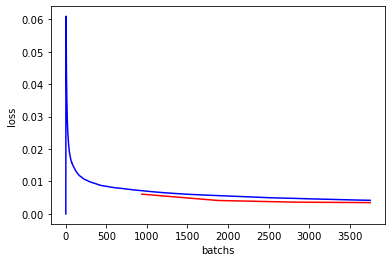

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
def plot(matrix_x,matrix_loss,entroy_x,entroy_loss):
    plt.plot(matrix_x,matrix_loss,color='b')
    plt.plot(entroy_x,entroy_loss,color='r')
    plt.xlabel('batchs')
    plt.ylabel('loss')
    
    
plot(matrix_x,matrix_loss,entroy_x,entroy_loss)